In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import re

In [58]:
# Load processed dataset
train_file_path = './train_lol_cleaned.csv'
data = pd.read_csv(train_file_path)
data.drop(["B_firstBlood", "B_firstTowerKill"], axis=1, inplace=True)

資料平衡性檢查

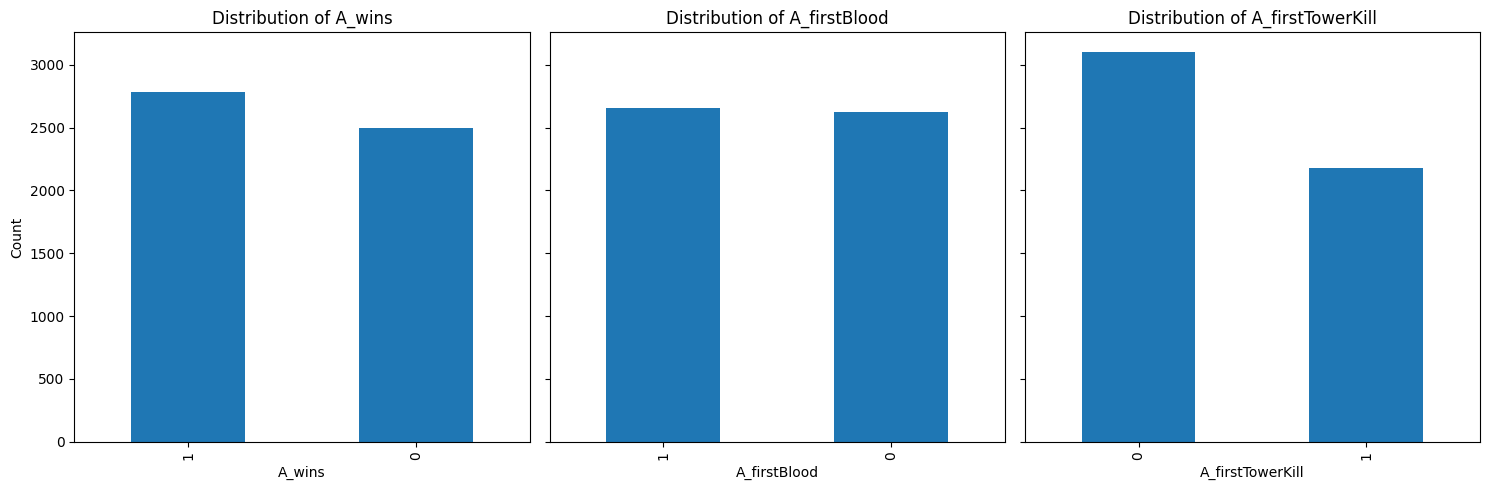

In [59]:
target_features = ["A_wins", "A_firstBlood", "A_firstTowerKill"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, target in enumerate(target_features):
    data[target].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Distribution of {target}")
    axes[i].set_xlabel(target)
    axes[i].set_ylabel("Count")
plt.tight_layout()
plt.show()

離群值檢查

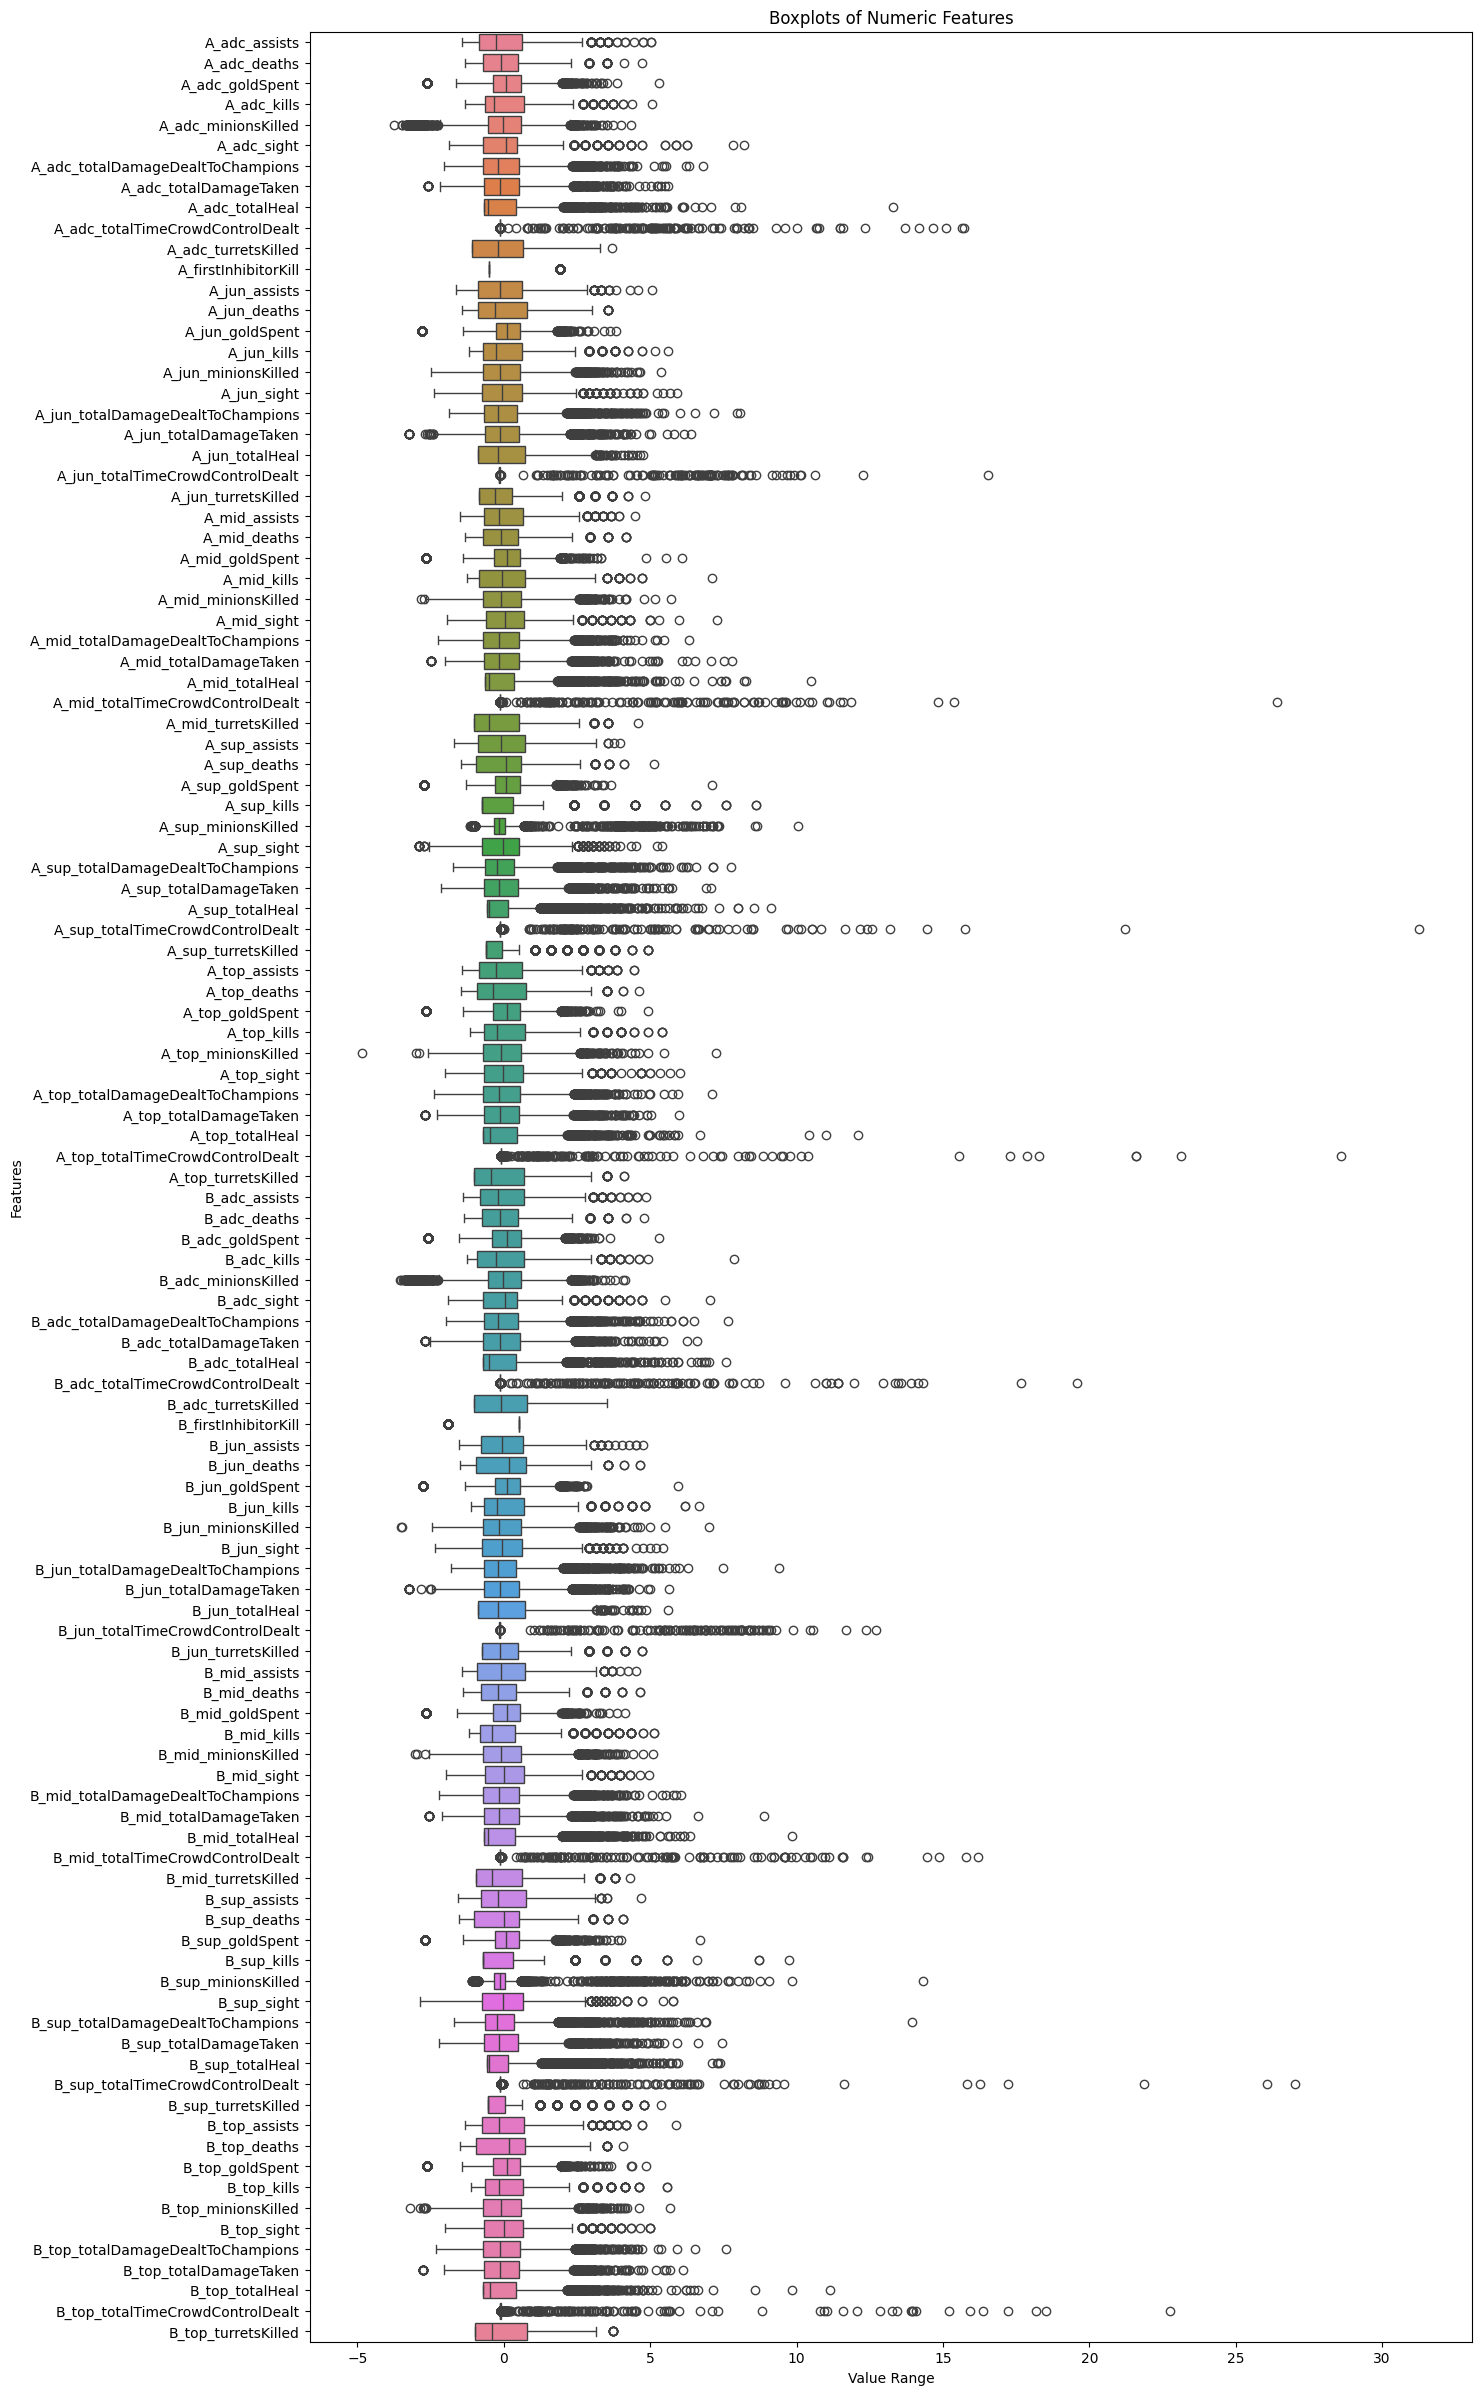

In [60]:
# 移除具有null values的feature: opScore, voidgrubs
op_scores = [col for col in data.columns if col.endswith('opScore')]
data.drop(op_scores + ['A_voidgrubs', 'B_voidgrubs'], axis=1, inplace=True)

# 選擇沒有固定上限的數值型特徵
fixed_upper_limit_features = [
    col for col in data.columns 
    if re.match(r"^(A|B)_(top|mid|adc|sup|jun)_(level|largestKillingSpree|largestMultiKill)$", col) or 
       re.match(r"^(A|B)_(baron_kills|dragon_kills|herald_kills|elder_dragon_kills|voidgrubs)$", col)
]
numeric_features = data.select_dtypes(include=["float64", "int64"]).columns
numeric_features = data.select_dtypes(include=["float64", "int64"]).columns.difference(target_features + fixed_upper_limit_features)

# 因資料尺度落差較大，先做數據標準化
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# 繪製box-plot
plt.figure(figsize=(15, 30))
sns.boxplot(data=data[numeric_features], orient="h")
plt.title("Boxplots of Numeric Features")
plt.xlabel("Value Range")
plt.ylabel("Features")
plt.show()

In [61]:
'''
為保留真實比賽數據，盡量不刪除離群值。
A/B_Role_totalTimeCrowdControlDealt這個特徵具大量離群值，故移除

'''
control_dealt = [col for col in data.columns if col.endswith('totalTimeCrowdControlDealt')]
data.drop(columns=control_dealt, axis=1, inplace=True)

隊伍勝負之特徵重要性分析

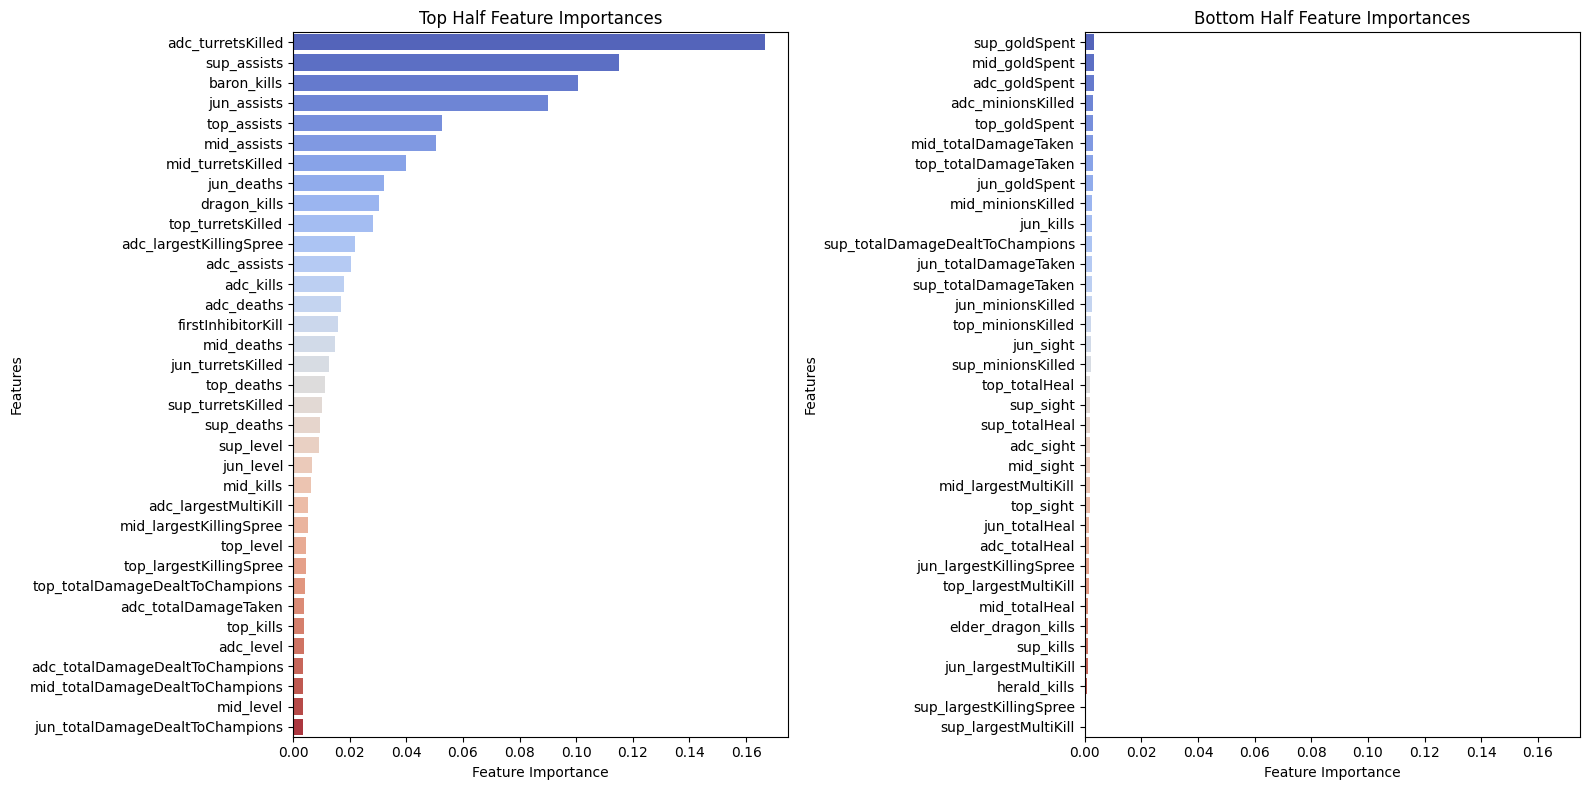

In [62]:
X = data.drop(columns=['game_date', 'A_teamname', 'B_teamname'] + target_features)
y = data['A_wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 資料標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 訓練隨機森林分類器
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# 提取特徵重要性
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})

# 合併相似特徵的重要性（A 和 B 隊伍）
feature_importances['BaseFeature'] = feature_importances['Feature'].str.replace(r'^[AB]_', '', regex=True)
grouped_importances = feature_importances.groupby('BaseFeature')['Importance'].sum().reset_index()

# 按特徵重要性排序
top_combined_features = grouped_importances.sort_values(by='Importance', ascending=False)

# 將特徵分為上下兩部分
mid_index = len(top_combined_features) // 2
top_half = top_combined_features.iloc[:mid_index]
bottom_half = top_combined_features.iloc[mid_index:]

# 繪製上下兩部分的特徵重要性
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# 上半部分
sns.barplot(x='Importance', y='BaseFeature', hue='BaseFeature', data=top_half, ax=axes[0], palette='coolwarm', dodge=False, legend=False)
axes[0].set_title('Top Half Feature Importances')
axes[0].set_xlabel('Feature Importance')
axes[0].set_ylabel('Features')

# 下半部分
sns.barplot(x='Importance', y='BaseFeature', hue='BaseFeature', data=bottom_half, ax=axes[1], palette='coolwarm', dodge=False, legend=False)
axes[1].set_title('Bottom Half Feature Importances')
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()


角色重要性分析

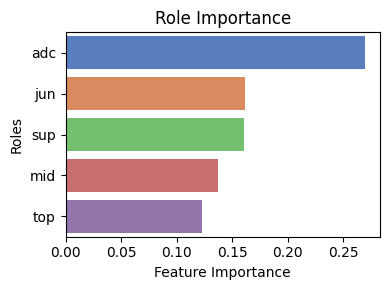

In [63]:
# 合併相似特徵的重要性（以角色 Role 合併）
feature_importances['RoleFeature'] = feature_importances['Feature'].str.extract(r'_(top|mid|adc|sup|jun)_')
grouped_importances = feature_importances.groupby('RoleFeature')['Importance'].sum().reset_index()

# 按特徵重要性排序
top_combined_features = grouped_importances.sort_values(by='Importance', ascending=False)

# 繪製特徵重要性
plt.figure(figsize=(4,3))
sns.barplot(x='Importance', y='RoleFeature', hue='RoleFeature', data=top_combined_features, palette='muted', dodge=False)
plt.title('Role Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Roles')
plt.tight_layout()
plt.show()



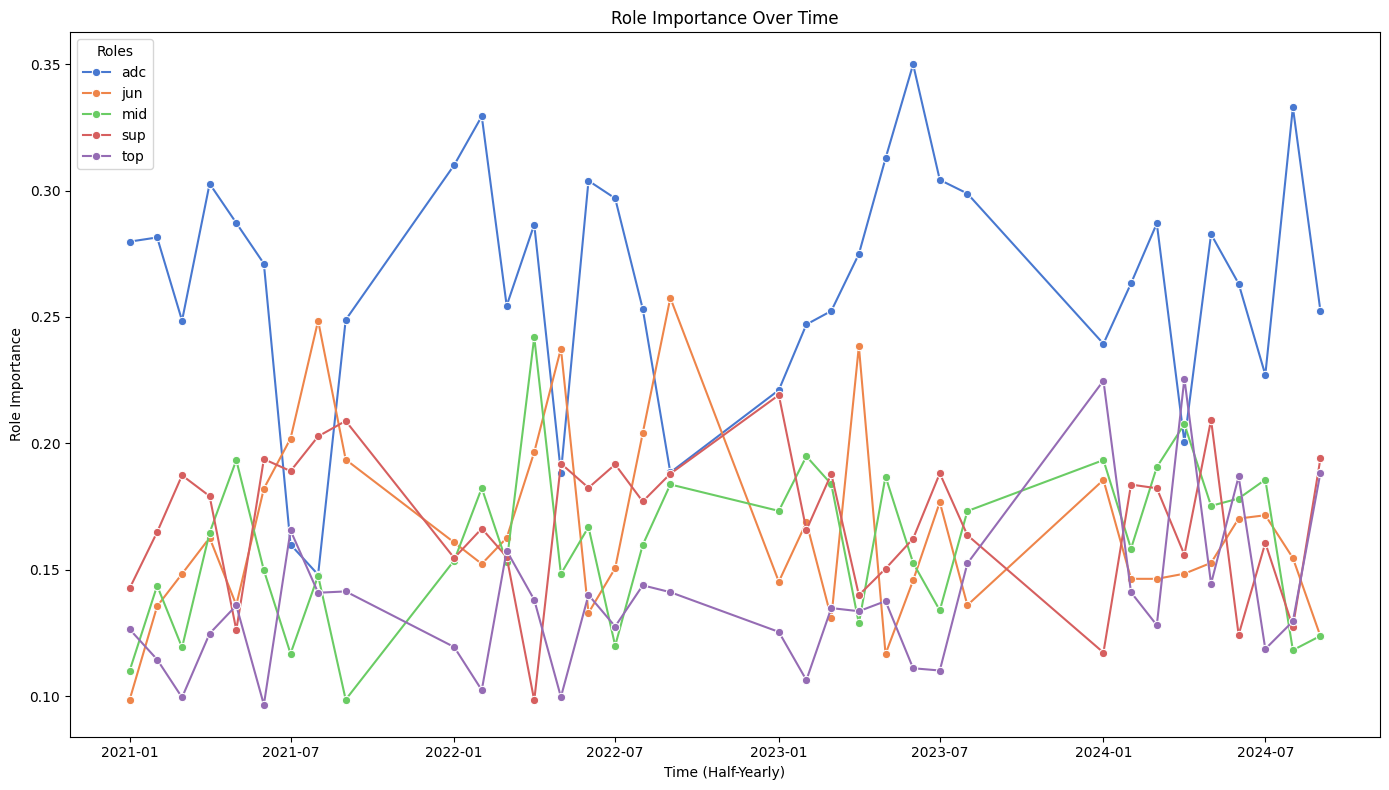

In [64]:
# 定義特徵和目標變數
X = data.drop(columns=['game_date', 'A_teamname', 'B_teamname'] + target_features)
y = data['A_wins']

# 將資料分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 資料標準化（僅對數值型特徵）
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_features]), columns=numeric_features, index=X_test.index)

# 加入時間序列資料
data['game_date'] = pd.to_datetime(data['game_date'], errors='coerce').dt.tz_localize(None)
data = data.assign(
    HalfYear=data['game_date'].dt.to_period('6M')
)

# 按半年分組資料
data_groups = []
for half_year, group in data.groupby('HalfYear'):
    group_indices = group.index
    X_group = X_train_scaled.loc[group_indices.intersection(X_train.index)]  # 從標準化的資料中篩選對應行
    y_group = y_train.loc[group_indices.intersection(y_train.index)]        # 篩選對應的目標變數
    if not X_group.empty:  # 確保分組資料不為空
        data_groups.append((half_year.start_time, X_group, y_group))

# 訓練 Random Forest 並分析每半年的特徵重要性
all_feature_importances = []
for half_year, X_group, y_group in data_groups:
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_group, y_group)

    feature_importances_group = pd.DataFrame({
        'Feature': X_group.columns,
        'Importance': rf.feature_importances_
    })
    feature_importances_group['HalfYear'] = half_year
    all_feature_importances.append(feature_importances_group)

# 合併所有的特徵重要性結果
combined_feature_importances = pd.concat(all_feature_importances)
combined_feature_importances['BaseFeature'] = combined_feature_importances['Feature'].str.replace(r'^[AB]_', '', regex=True)
combined_feature_importances['Role'] = combined_feature_importances['BaseFeature'].str.extract(r'(top|jun|mid|adc|sup)_')

# 按角色和時間計算總特徵重要性
role_importances_over_time = combined_feature_importances.groupby(['HalfYear', 'Role'])['Importance'].sum().reset_index()
role_importances_over_time['SmoothedImportance'] = role_importances_over_time.groupby('Role')['Importance'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 繪製角色重要性隨時間的變化圖
plt.figure(figsize=(14, 8))
sns.lineplot(x='HalfYear', y='Importance', hue='Role', data=role_importances_over_time, marker='o', palette='muted')
plt.title('Role Importance Over Time')
plt.xlabel('Time (Half-Yearly)')
plt.ylabel('Role Importance')
plt.legend(title='Roles', loc='upper left')
plt.tight_layout()
plt.show()

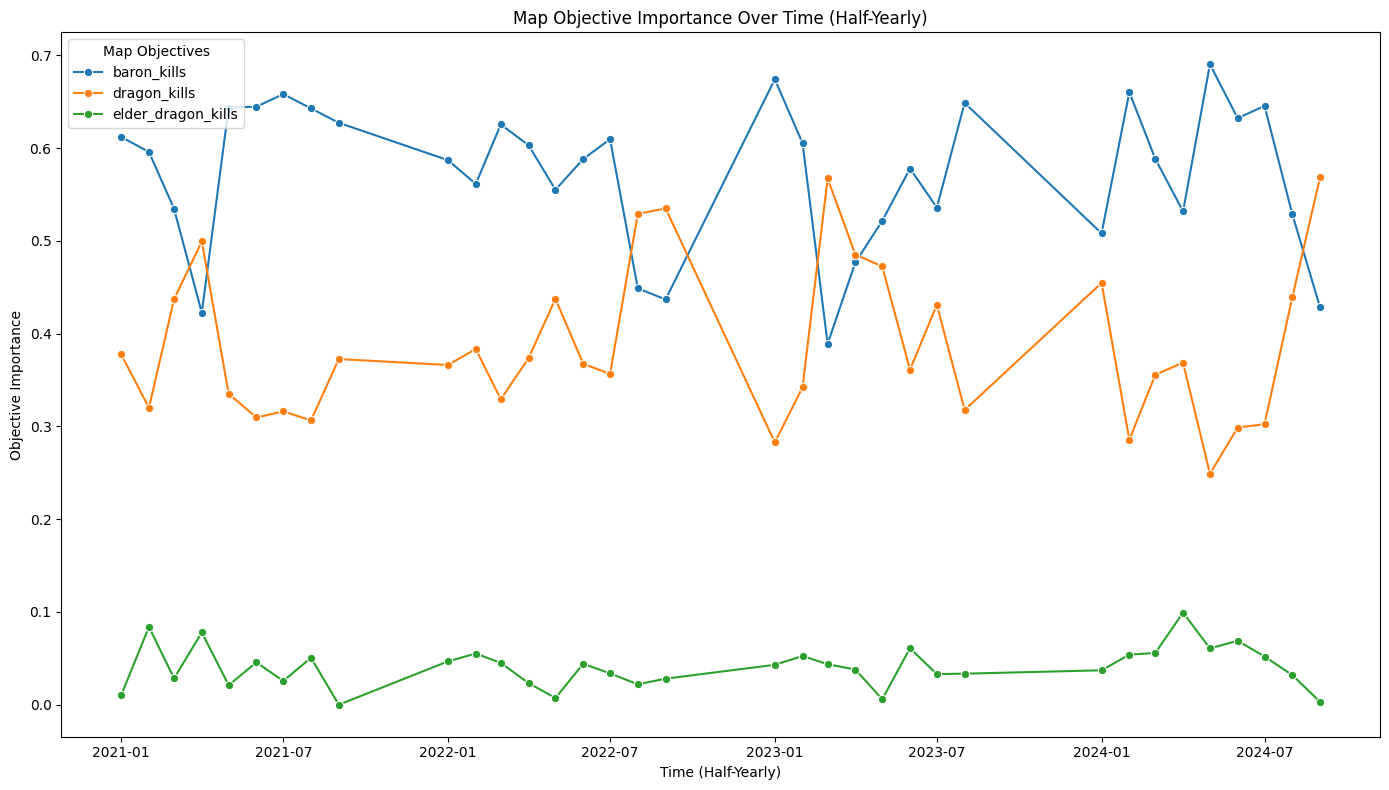

In [65]:
# 定義地圖物件特徵
map_object_features = ['baron_kills', 'dragon_kills', 'elder_dragon_kills']

# 加入時間序列資料
data['game_date'] = pd.to_datetime(data['game_date'], errors='coerce')
data['game_date'] = data['game_date'].dt.tz_localize(None)
data['HalfYear'] = data['game_date'].dt.to_period('6M')

# 將特徵分組並創建數據組
data_groups = []
for half_year, group in data.groupby('HalfYear'):
    X_group = group[[f"A_{feat}" for feat in map_object_features] + [f"B_{feat}" for feat in map_object_features]]
    y_group = group['A_wins']
    if not X_group.empty:  # 確保分組資料不為空
        data_groups.append((half_year.start_time, X_group, y_group))

# 訓練隨機森林模型並分析每半年地圖物件的重要性
all_feature_importances = []
for half_year, X_group, y_group in data_groups:
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_group, y_group)

    feature_importances_group = pd.DataFrame({
        'Feature': X_group.columns,
        'Importance': rf.feature_importances_
    })
    feature_importances_group['HalfYear'] = half_year
    all_feature_importances.append(feature_importances_group)

# 合併所有特徵重要性結果
combined_feature_importances = pd.concat(all_feature_importances)
combined_feature_importances['BaseFeature'] = combined_feature_importances['Feature'].str.replace(r'^[AB]_', '', regex=True)

# 按地圖物件類型分組並計算總重要性
object_importances_over_time = combined_feature_importances.groupby(['HalfYear', 'BaseFeature'])['Importance'].sum().reset_index()

# 繪製地圖物件重要性隨時間變化的折線圖
plt.figure(figsize=(14, 8))
sns.lineplot(x='HalfYear', y='Importance', hue='BaseFeature', data=object_importances_over_time, marker='o')
plt.title('Map Objective Importance Over Time (Half-Yearly)')
plt.xlabel('Time (Half-Yearly)')
plt.ylabel('Objective Importance')
plt.legend(title='Map Objectives', loc='upper left')
plt.tight_layout()
plt.show()


分析單一隊伍(需重新整理資料)

In [66]:
# 資料集重新整理: 每列只包含一個隊伍的資料，`teamname` 列表示隊伍名稱，`wins` 表示該隊伍的勝負
# A 隊伍用teamname重新命名特徵
team_a_data = data.copy()
team_a_data.columns = [
    col.replace('A_', '').replace('B_', '') if col.startswith('A_') else col
    for col in team_a_data.columns
]
team_a_data = team_a_data.rename(columns={'A_teamname': 'teamname', 'A_wins': 'wins'})

if 'B_teamname' in team_a_data.columns:
    team_a_data = team_a_data.drop(columns=['B_teamname'])

# B 隊伍用teamname重新命名特徵
team_b_data = data.copy()
team_b_data['B_wins'] = 1 - data['A_wins']  # 若 A_wins 是 1，則 B_wins 為 0，反之亦然
team_b_data.columns = [
    col.replace('B_', '').replace('A_', '') if col.startswith('B_') else col
    for col in team_b_data.columns
]
team_b_data = team_b_data.rename(columns={'B_teamname': 'teamname', 'B_wins': 'wins'})

if 'A_teamname' in team_b_data.columns:
    team_b_data = team_b_data.drop(columns=['A_teamname'])

# 合併 A 和 B 資料集
common_columns = team_a_data.columns.intersection(team_b_data.columns)
team_a_data = team_a_data[common_columns]
team_b_data = team_b_data[common_columns]
combined_data = pd.concat([team_a_data, team_b_data], ignore_index=True)
combined_data = combined_data.sort_values(by=['teamname', 'game_date']).reset_index(drop=True)
# print(combined_data.head())
# combined_data.to_csv('temp.csv', index=False, encoding='utf-8')


隊伍勝率分析

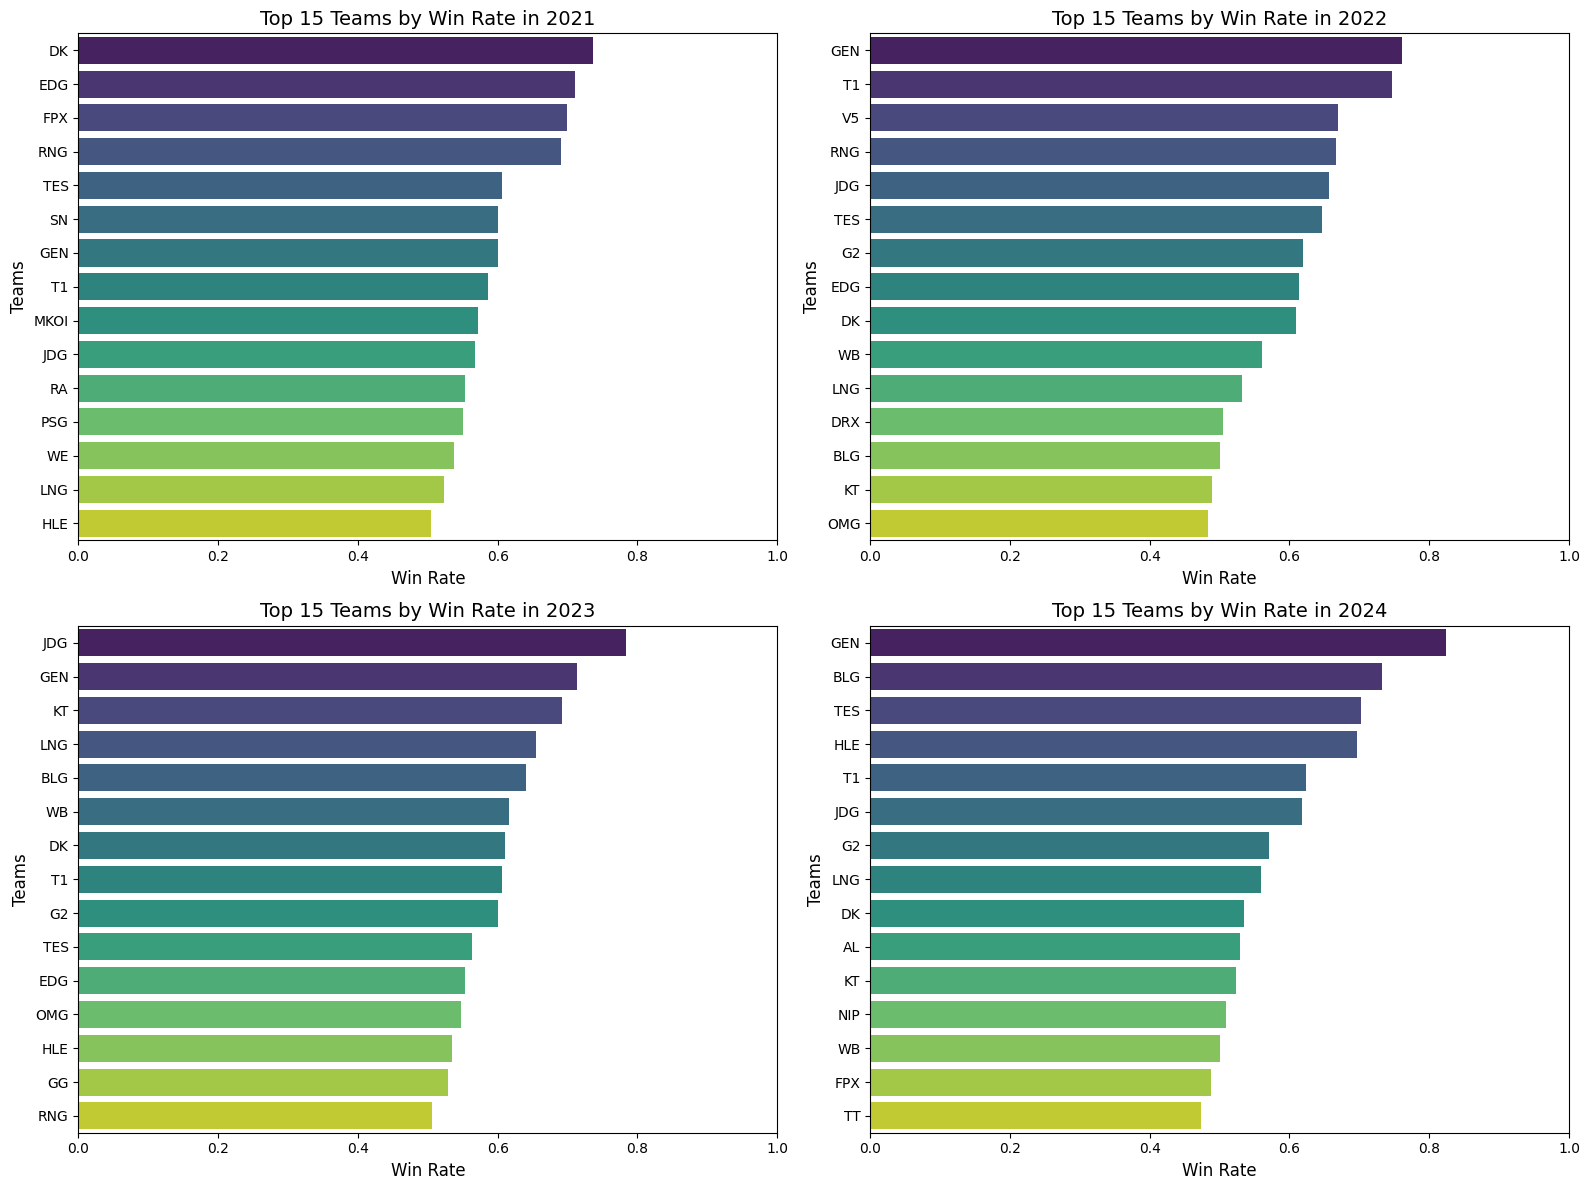

In [67]:
# 提取年份
combined_data['YearMonth'] = combined_data['game_date'].dt.to_period('M')  # 按月
combined_data['Year'] = combined_data['game_date'].dt.year  # 提取年份

# 計算每隊每年的勝率
win_rate_by_team_year = combined_data.groupby(['teamname', 'Year'])['wins'].mean().reset_index()
years = win_rate_by_team_year['Year'].unique()

# 繪製圖表
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for i, year in enumerate(years):
    data_year = win_rate_by_team_year[win_rate_by_team_year['Year'] == year]
    data_year = data_year.sort_values(by='wins', ascending=False).head(15)  #僅繪製勝率前15的隊伍

    sns.barplot(x='wins', y='teamname', hue='teamname', data=data_year, ax=axes[i], palette='viridis', dodge=False)
    axes[i].set_title(f'Top 15 Teams by Win Rate in {year}', fontsize=14)
    axes[i].set_xlabel('Win Rate', fontsize=12)
    axes[i].set_ylabel('Teams', fontsize=12)
    axes[i].set_xlim(0, 1)

plt.tight_layout()
plt.show()

隊伍滾動式勝率趨勢圖

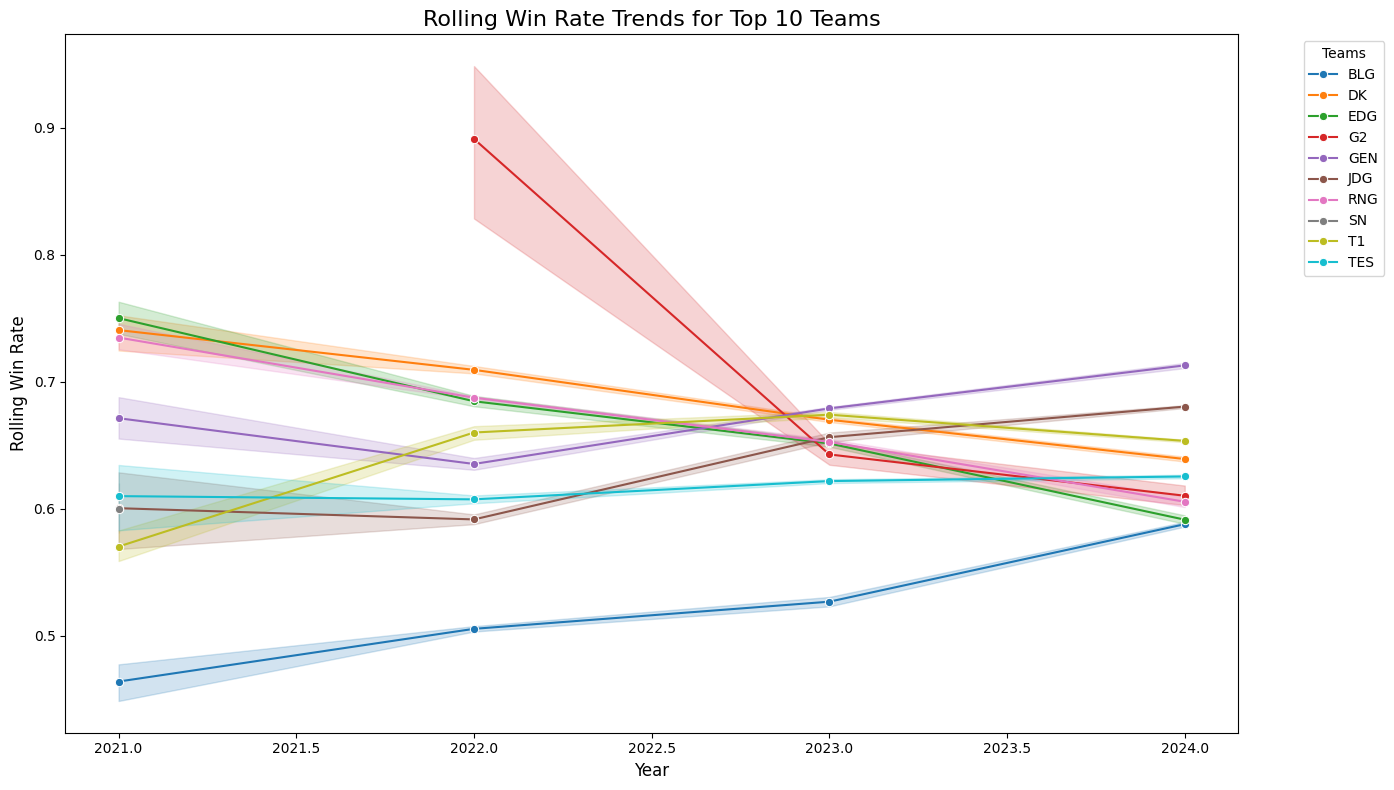

In [68]:
# 確保年份資訊存在
combined_data['Year'] = combined_data['YearMonth'].dt.year

# 計算滾動式勝率
combined_data = combined_data.sort_values(by=['teamname', 'Year'])  # 確保按隊伍和年份排序
combined_data['rolling_win_rate'] = combined_data.groupby('teamname')['wins'].transform(lambda x: x.expanding().mean())

# 取得前10支隊伍
overall_win_rate = combined_data.groupby('teamname')['wins'].mean().reset_index()
overall_win_rate = overall_win_rate.sort_values(by='wins', ascending=False).head(10)
top_teams = overall_win_rate['teamname']

# 篩選前10支隊伍的數據
top_teams_data = combined_data[combined_data['teamname'].isin(top_teams)]

# 繪製滾動式勝率趨勢圖
plt.figure(figsize=(14, 8))
sns.lineplot(
    x='Year', y='rolling_win_rate', hue='teamname', data=top_teams_data, marker='o', palette='tab10'
)
plt.title('Rolling Win Rate Trends for Top 10 Teams', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rolling Win Rate', fontsize=12)
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()